# CM3070 Final Year Project

In [10]:
# import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from transformers import InputExample, InputFeatures
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TFRobertaForSequenceClassification, RobertaTokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

metric_names = ['Accuracy', 'F1-score', 'Precision', 'Recall']
cm_metrics = ['True Positive', 'False Positive','False Negative', 'True Negative']
label_names = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# set plot style of matplotlib
plt.style.use('default')

## Data preparation

Split the stock price data into training, test and validation sets. The LSTM model works best with a large dataset, so 80% of the data will be used for training, 10% for validation and 10% for testing. This is seen when 70% of the data is used for training, 15% for validation and 15% for testing. The model is not able to learn the patterns in the data and the predictions are not accurate. This is deduced from the evaluation metrics of the model with 70% of the data used for training, compared to the model with 80% of the data used for training.

In [11]:
# load the S&P 500 stock price dataset
df_time_series = pd.read_csv('SPX.csv')

# convert the 'Date' column to datetime format
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])

# Keep only the 'Date' and 'Adj Close' columns
df_time_series = df_time_series[['Date', 'Adj Close']]

# Calculate the index to split the data into 80% train and 20% test
split_index_train_test = int(len(df_time_series) * 0.8)

# Split the data into train and test sets
time_train_data = df_time_series[:split_index_train_test]
time_test_data = df_time_series[split_index_train_test:]

split_index_val_test = int(len(time_test_data) * 0.5)

# Split the test data into validation and test sets
time_validation_data = time_test_data[:split_index_val_test]
time_test_data = time_test_data[split_index_val_test:]

# Print the shapes of the train, validation and test sets
print("Train data shape:", time_train_data.shape)
print("Validation data shape:", time_validation_data.shape)
print("Test data shape:", time_test_data.shape)

Train data shape: (519, 2)
Validation data shape: (65, 2)
Test data shape: (65, 2)


In [12]:
# load the news headlines dataset
df_headlines = pd.read_csv('combined.csv')

# Convert the 'Date' column to datetime
df_headlines['Date'] = pd.to_datetime(df_headlines['Date'])

# Show the first 5 rows of the dataframe
df_headlines.head()

,Headlines,Date,finvader,Source,Label,finvader_rounded
0,The Guardian view on Ryanair’s model: a union-...,2017-12-17,0.0000,Guardian,2,0.0
1,Hundreds to lose jobs as Britvic shuts down No...,2017-12-17,-0.3716,Guardian,1,-0.4
2,British Steel pension scheme members ‘preyed o...,2017-12-17,0.0000,Guardian,2,0.0
3,‘Going to the Furniture Ombudsman about our so...,2017-12-17,-0.0116,Guardian,2,-0.0
4,"Uber stole trade secrets, bribed foreign offic...",2017-12-17,0.0717,Guardian,3,0.1


The news headlines data are split into training, test and validation sets based on the dates of the stock price data. The most important split is the test set, as that will be the evaluation set for the RoBERTa and LSTM models. 

The test set for the news headlines data are extracted to correspond with the test set of the stock price data. The training and validation sets are then split based on the remaining data. 

This is to ensure that the test data is not in the train data to train the model. Ensures that the model is not overfitting the data and is able to generalise to new and unseen data.

There are dates without news headlines data but have stock price data and vice versa. The sentiment scores without stock price data to match are first added together with the next date with stock price data. The new weighted average of the sentiment scores is then calculated and used as the sentiment score for that date. 

For example, 2017-12-30 and 2017-12-31 have news headlines data but no stock price data. The sentiment scores for 2017-12-30 and 2017-12-31 are added together with the next date with stock price data, 2018-01-02. The new weighted average of the sentiment scores is then calculated and used as the sentiment score for 2018-01-02.

This is to get a better representation of the sentiment score for that date. The dates without stock price data are then removed. 

In [13]:
def preprocess_stock_data_labels(df_time, df_headlines):
    # Create a dataframe with continuous dates
    df = pd.DataFrame({'Date': pd.date_range(start=df_time['Date'].min(), end=df_time['Date'].max())})

    headlines_labels = df_headlines[df_headlines['Date'].isin(df['Date'])]

    headlines_labels_weighted_avg = headlines_labels.groupby('Date')['Label'].mean()

    # Merge the continuous dates dataframe with time_train_data
    df = df.merge(df_time, how='left', on='Date')

    # Fill dates without data with NaN
    df.fillna(np.nan, inplace=True)
    
    # Merge the stock price data with the news headlines labels
    df = df.merge(headlines_labels_weighted_avg, how='left', on='Date')

    labels = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Check if Adj Close is NaN and Label is not NaN
        if pd.isna(row['Adj Close']) and not pd.isna(row['Label']):
            # Append the Label to the list
            labels.append(row['Label'])
        elif not pd.isna(row['Adj Close']):
            # Calculate the weighted average of labels
            if len(labels) > 0:
                if not pd.isna(row['Label']):
                    labels.append(row['Label'])
                weighted_avg = np.mean(labels)
                # Update the Label column with the weighted average
                df.at[index, 'Label'] = weighted_avg
            # Clear the labels list
            labels = []

    df.dropna(subset=['Adj Close'], inplace=True)
    
    df['Label'].fillna(0, inplace=True)

    df.set_index('Date', inplace=True)
    
    return df

In [14]:
time_train_data = preprocess_stock_data_labels(time_train_data, df_headlines)
time_train_data.head()

,Adj Close,Label
Date,,
2017-12-18,2690.159912,1.950000
2017-12-19,2681.469971,1.750000
2017-12-20,2679.250000,1.700000
2017-12-21,2684.570068,1.850000
2017-12-22,2683.340088,2.043478


In [15]:
time_validation_data = preprocess_stock_data_labels(time_validation_data, df_headlines)
time_validation_data.head()

,Adj Close,Label
Date,,
2020-01-13,3288.129883,1.939394
2020-01-14,3283.149902,1.869565
2020-01-15,3289.290039,2.228916
2020-01-16,3316.810059,2.088608
2020-01-17,3329.620117,2.000000


In [16]:
time_test_data = preprocess_stock_data_labels(time_test_data, df_headlines)
time_test_data.head()

,Adj Close,Label
Date,,
2020-04-16,2799.550049,1.903846
2020-04-17,2874.560059,1.915094
2020-04-20,2823.159912,1.922009
2020-04-21,2736.560059,1.831933
2020-04-22,2799.310059,1.805970


In [17]:
# Create a dataframe with dates for the test set
df_test_dates = pd.DataFrame({'Date': pd.date_range(start=time_test_data.index.min(), end=time_test_data.index.max())})

# Merge data with the same dates into df_test_headlines
df_test_headlines = df_headlines[df_headlines['Date'].isin(df_test_dates['Date'])]

df_test_headlines.head()

,Headlines,Date,finvader,Source,Label,finvader_rounded
46926,Thailand expects liquidity support for Thai Ai...,2020-04-16,0.0142,Reuters,2,0.0
46927,"Etihad has full support of state owner, will r...",2020-04-16,0.0271,Reuters,2,0.0
46928,Ford's first-quarter China vehicle sales down ...,2020-04-16,-0.3527,Reuters,1,-0.4
46929,Bentley extends UK production shutdown by thre...,2020-04-16,-0.0626,Reuters,1,-0.1
46930,Some Accor hotels to admit mild coronavirus ca...,2020-04-16,0.2083,Reuters,3,0.2


In [18]:
# Obtain remaining headlines for training and validation
df_train_val_headlines = pd.concat([df_headlines[df_headlines['Date'] > time_test_data.index.max()],
                                    df_headlines[df_headlines['Date'] < time_test_data.index.min()]])

# Split the remaining headlines into training and validation sets (90% train, 10% validation)
df_train_headlines, df_val_headlines = train_test_split(df_train_val_headlines,
                                                        test_size=0.1,
                                                        stratify=df_train_val_headlines['Label'],
                                                        random_state=12345)

In [19]:
print("No. of headlines in train set:", len(df_train_headlines))
for label, count in df_train_headlines['Label'].value_counts().items():
    print("Number of", label, ":", count)

No. of headlines in train set: 42255
Number of 2 : 21322
Number of 1 : 9833
Number of 3 : 8253
Number of 0 : 1496
Number of 4 : 1351


In [20]:
print("No. of headlines in validation set:", len(df_val_headlines))
for label, count in df_val_headlines['Label'].value_counts().items():
    print("Number of", label, ":", count)

No. of headlines in validation set: 4695
Number of 2 : 2369
Number of 1 : 1093
Number of 3 : 917
Number of 0 : 166
Number of 4 : 150


In [21]:
print("No. of headlines in test set:", len(df_test_headlines))
for label, count in df_test_headlines['Label'].value_counts().items():
    print("Number of", label, ":", count)

No. of headlines in test set: 6380
Number of 2 : 3111
Number of 1 : 1643
Number of 3 : 1238
Number of 0 : 220
Number of 4 : 168


## RoBERTa model

Initialise "roberta-base" for TFRobertaForSequenceClassification and RobertaTokenizerFast. "roberta-base" is case-sensitive by default, meaning that it will treat words like "apple" and "Apple" as different tokens. This is crucial as news headlines that affect stock prices generally include entity names, such as Apple, Google, etc. This will help the model differentiate between entities and non-entities.

In [22]:
# initialize the model and tokenizer
roberta_model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5)
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [26]:
# function for converting df to inputs
def headlines_to_inputs(df):
    encodings = roberta_tokenizer.batch_encode_plus(
        df.tolist(),  # sentences to encode
        add_special_tokens=True,  # add [CLS], [SEP]
        max_length=128,  # max length of the text that can go to RoBERTa
        padding=True,  # add [PAD] tokens
        truncation=True,  # truncate sentences longer than max_length
        return_tensors='tf',  # return tensorflow tensor
    )

    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']

    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
    }

    return inputs

In [27]:
train_headlines_inputs = headlines_to_inputs(df_train_headlines['Headlines'])
val_headlines_inputs = headlines_to_inputs(df_val_headlines['Headlines'])
test_headlines_inputs = headlines_to_inputs(df_test_headlines['Headlines'])

In [28]:
train_labels = df_train_headlines['Label']
validation_labels = df_val_headlines['Label']
test_labels = df_test_headlines['Label']

train_labels_inputs = tf.convert_to_tensor(train_labels)
validation_labels_inputs = tf.convert_to_tensor(validation_labels)

In [29]:
train_inputs = tf.data.Dataset.from_tensor_slices((train_headlines_inputs, train_labels_inputs)).shuffle(100).batch(32)
validation_inputs = tf.data.Dataset.from_tensor_slices((val_headlines_inputs, validation_labels_inputs)).batch(32)

In [18]:
# Compile the RoBERTa model with Adam optimizer and SparseCategoricalAccuracy loss
# SparseCategoricalAccuracy is used because the labels are not one-hot encoded
roberta_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-8, clipnorm=1.0),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# train the model and save the history
early_stopping_history = roberta_model.fit(train_inputs, epochs=10, validation_data=validation_inputs, callbacks=[early_stopping])

# Save the model
roberta_model.save_pretrained('./Model/RobertaModel_Final')

Epoch 1/10
1321/1321 [==============================] - 4336s 3s/step - loss: 0.5905 - accuracy: 0.7991 - val_loss: 0.3531 - val_accuracy: 0.8903
Epoch 2/10
1321/1321 [==============================] - 3841s 3s/step - loss: 0.2825 - accuracy: 0.9131 - val_loss: 0.2516 - val_accuracy: 0.9203
Epoch 3/10
1321/1321 [==============================] - 3844s 3s/step - loss: 0.1943 - accuracy: 0.9409 - val_loss: 0.2272 - val_accuracy: 0.9321
Epoch 4/10
1321/1321 [==============================] - 3894s 3s/step - loss: 0.1509 - accuracy: 0.9541 - val_loss: 0.2022 - val_accuracy: 0.9412
Epoch 5/10
1321/1321 [==============================] - 3804s 3s/step - loss: 0.1183 - accuracy: 0.9637 - val_loss: 0.1978 - val_accuracy: 0.9429
Epoch 6/10
1321/1321 [==============================] - 3827s 3s/step - loss: 0.0910 - accuracy: 0.9715 - val_loss: 0.2174 - val_accuracy: 0.9453
Epoch 7/10
1321/1321 [==============================] - 3864s 3s/step - loss: 0.0754 - accuracy: 0.9755 - val_loss: 0.2275 -

In [19]:
print(early_stopping.stopped_epoch)

6


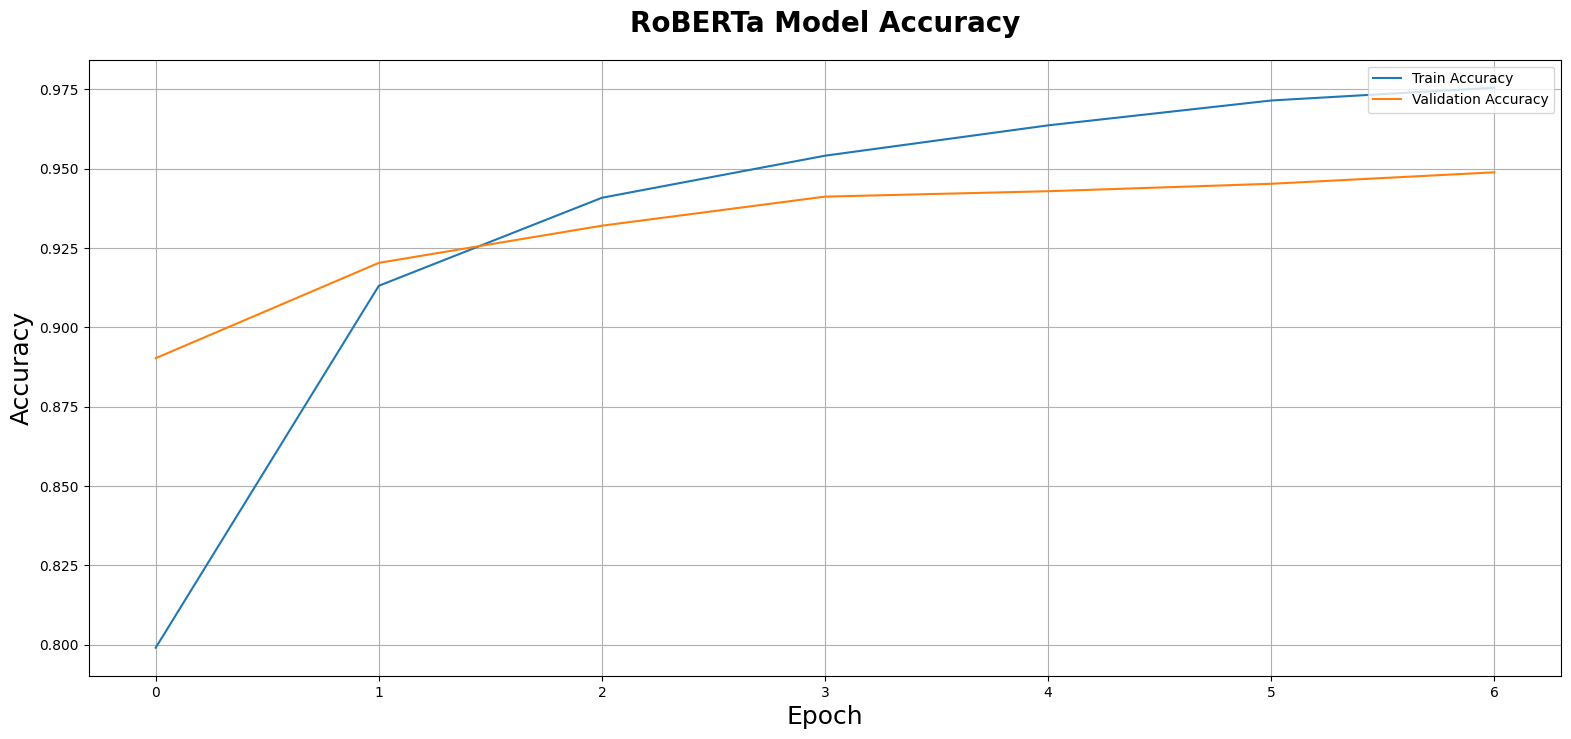

In [40]:
# Plot the training and validation accuracy
plt.figure(figsize=(19, 8))
plt.plot(early_stopping_history.history['accuracy'], label='Train Accuracy')
plt.plot(early_stopping_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RoBERTa Model Accuracy', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()

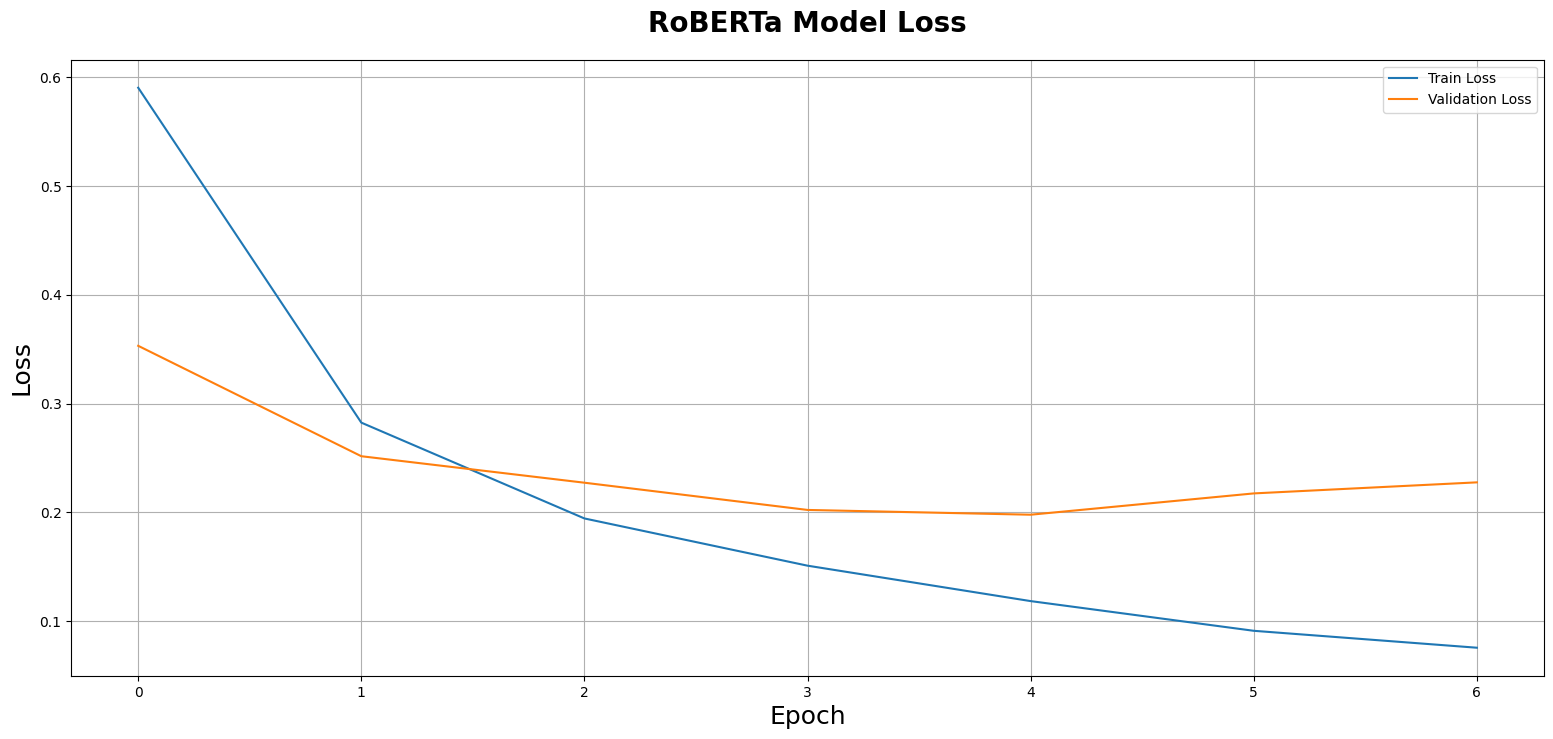

In [39]:
# Plot the training and validation loss
plt.figure(figsize=(19, 8))
plt.plot(early_stopping_history.history['loss'], label='Train Loss')
plt.plot(early_stopping_history.history['val_loss'], label='Validation Loss')
plt.title('RoBERTa Model Loss', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()

### RoBERTa Model Evaluation

In [30]:
roberta_model = TFRobertaForSequenceClassification.from_pretrained('./Model/RobertaModel_Final')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./Model/RobertaModel_Final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
roberta_outputs = roberta_model(test_headlines_inputs)
tf_test_predictions = tf.nn.softmax(roberta_outputs[0], axis=-1)
roberta_predictions = tf.argmax(tf_test_predictions, axis=1)
roberta_predictions = roberta_predictions.numpy()

RoBERTa model:
Accuracy score: 94.09%
F1-score: 94.08%
Precision score: 94.12%
Recall score: 94.09%


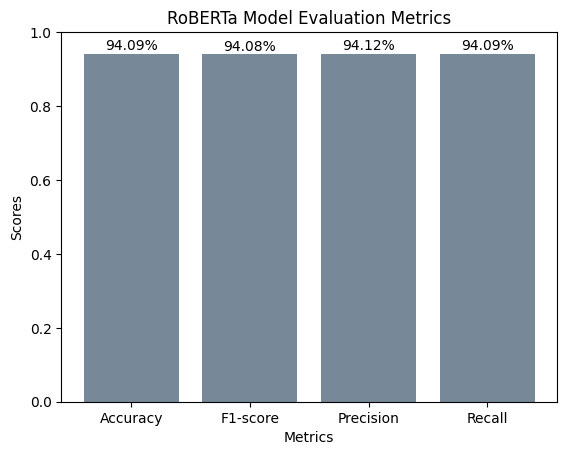

In [32]:
roberta_true_labels = df_test_headlines['Label'].tolist()

# calculate the accuracy score for the BERT model
roberta_acc = accuracy_score(roberta_true_labels, roberta_predictions)

# calculate the F1-score for the BERT model
roberta_f1 = f1_score(
    roberta_true_labels, roberta_predictions, average='weighted')

# calculate the precision score for the BERT model
roberta_precision = precision_score(
    roberta_true_labels, roberta_predictions, average='weighted')

# calculate the recall score for the BERT model
roberta_recall = recall_score(
    roberta_true_labels, roberta_predictions, average='weighted')

bert_metrics = [roberta_acc, roberta_f1, roberta_precision, roberta_recall]

print('RoBERTa model:')
print("Accuracy score: {:.2%}".format(roberta_acc))
print("F1-score: {:.2%}".format(roberta_f1))
print("Precision score: {:.2%}".format(roberta_precision))
print("Recall score: {:.2%}".format(roberta_recall))

# plot the graph for evaluation metrics
plt.bar(metric_names, bert_metrics, color=['lightslategray'])
plt.title('RoBERTa Model Evaluation Metrics')
plt.ylim(0.0, 1.0)
plt.xlabel('Metrics')
plt.ylabel('Scores')
for i, v in enumerate(bert_metrics):
    plt.text(i,  v + 0.01, '{:.2%}'.format(v), ha='center')
plt.show()

In [33]:
# print classification report 
print("Classification Report for RoBERTa Model:")
print(classification_report(roberta_true_labels, roberta_predictions, target_names=label_names))        

Classification Report for RoBERTa Model:
               precision    recall  f1-score   support

Very Negative       0.80      0.81      0.81       220
     Negative       0.95      0.92      0.93      1643
      Neutral       0.96      0.98      0.97      3111
     Positive       0.93      0.91      0.92      1238
Very Positive       0.82      0.92      0.87       168

     accuracy                           0.94      6380
    macro avg       0.89      0.91      0.90      6380
 weighted avg       0.94      0.94      0.94      6380



RoBERTa Confusion Matrix: 
 [[ 178   33    7    1    1]
 [  40 1505   72   26    0]
 [   3   25 3037   44    2]
 [   1   18   60 1129   30]
 [   0    0    4   10  154]]


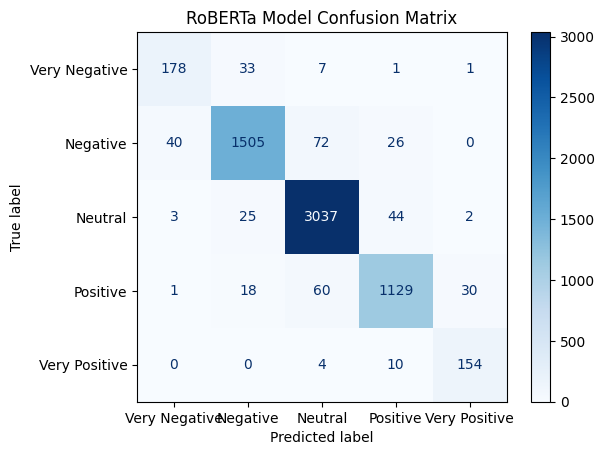

In [39]:
roberta_cm = confusion_matrix(roberta_true_labels, roberta_predictions)

print("RoBERTa Confusion Matrix: \n", roberta_cm)

roberta_displayCM = ConfusionMatrixDisplay(
    confusion_matrix=roberta_cm, display_labels=label_names)
roberta_displayCM.plot(cmap='Blues')
plt.title('RoBERTa Model Confusion Matrix')
plt.show()

## BERT model

In [35]:
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# function for converting df to InputExamples
def df_to_InputExamples(df_headlines, df_labels):
    df = pd.DataFrame({'headlines': df_headlines, 'labels': df_labels})
    # create InputExamples
    input_examples = []
    for i in range(df_headlines.shape[0]):
        input_examples.append(
            InputExample(
                guid="",
                text_a=df.iloc[i][0],
                text_b=None,
                label=df.iloc[i][1]
            )
        )
    return list(input_examples)

In [51]:
# function to convert InputExample format data into tf_dataset format
def examples_to_tensorflow_dataset(examples, tokenizer, max_length=128):
    features = []  # list to store InputFeatures

    for e in examples:
        # using tokenizer to encode text into tokens, pad and truncate to max_length
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,  # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            # pads to the right by default # CHECK THIS for pad_to_max_length
            padding='max_length',
            truncation=True
        )

        # extract encoded input_ids, token_type_ids and attention_mask
        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                     input_dict["token_type_ids"], input_dict['attention_mask'])

        # append InputFeatures to features list
        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        # generate the input feature and label pairs
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    # convert generated input feature and label pairs into TensorFlow dataset
    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32,
         "token_type_ids": tf.int32}, tf.float32),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [52]:
bert_train = df_to_InputExamples(df_train_headlines['Headlines'], df_train_headlines['Label'])
bert_val = df_to_InputExamples(df_val_headlines['Headlines'], df_val_headlines['Label'])

In [53]:
# convert train data InputExample into tf_dataset format & shuffle and batch the dataset
train_inputs = examples_to_tensorflow_dataset(bert_train, bert_tokenizer, 128).shuffle(100).batch(32)

# convert validation data InputExample into tf_dataset format & batch the dataset
validation_inputs = examples_to_tensorflow_dataset(bert_val, bert_tokenizer, 128).batch(32)

In [ ]:
# Compile the BERT model with Adam optimizer and SparseCategoricalAccuracy loss
# SparseCategoricalAccuracy is used because the labels are not one-hot encoded
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-8, clipnorm=1.0),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# train the model and save the history
history = bert_model.fit(train_inputs, epochs=10,
                         validation_data=validation_inputs, callbacks=[early_stopping])

# Save the model
bert_model.save_pretrained('./Model/BERTModel_Final')

In [19]:
print(early_stopping.stopped_epoch)

4


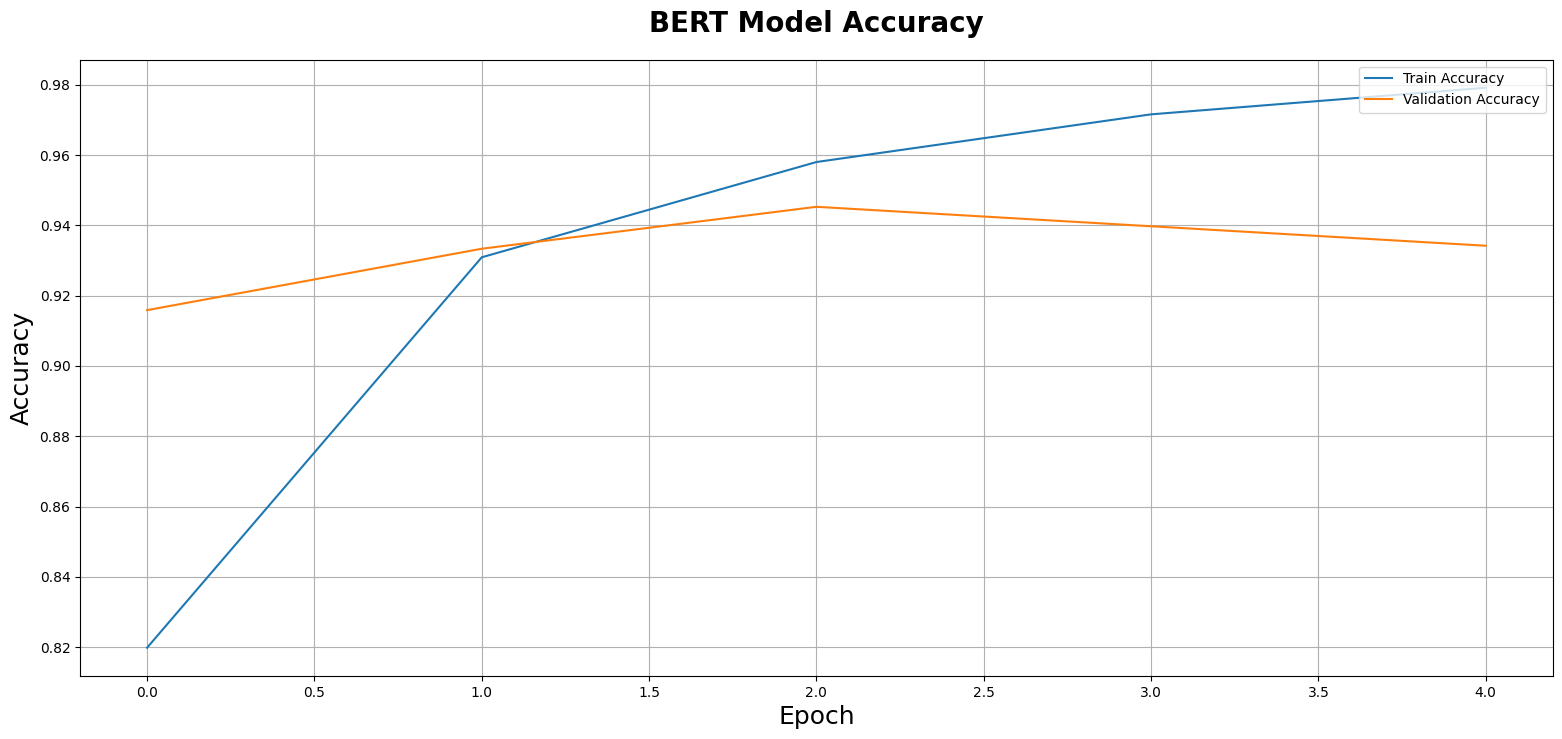

In [20]:
# Plot the training and validation accuracy
plt.figure(figsize=(19, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BERT Model Accuracy', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()

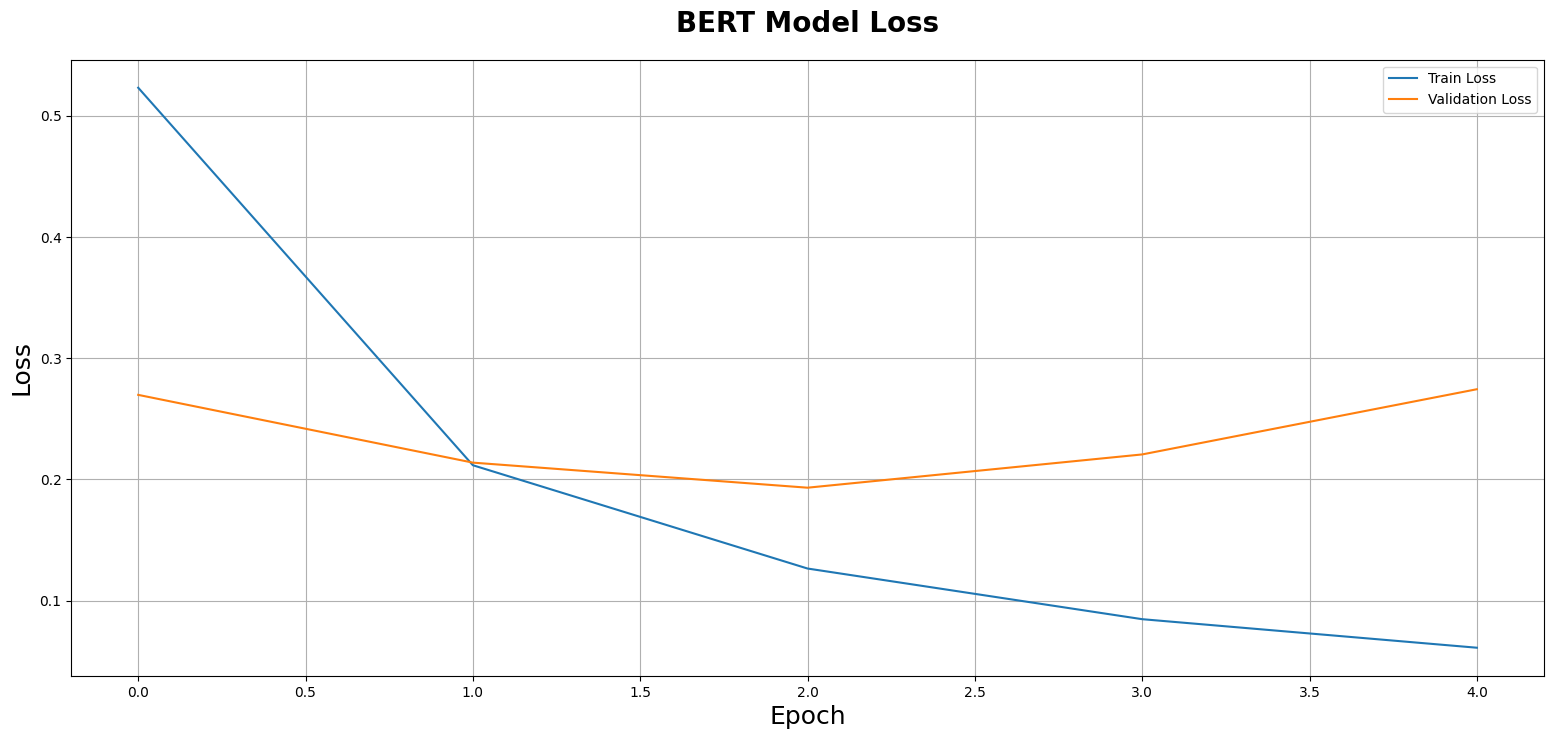

In [21]:
# Plot the training and validation loss
plt.figure(figsize=(19, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('BERT Model Loss', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()

### BERT Model Evaluation

In [42]:
bert_model = TFBertForSequenceClassification.from_pretrained('./Model/BERTModel_Final')

Some layers from the model checkpoint at ./Model/BERTModel_Final were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./Model/BERTModel_Final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
test_headlines = df_test_headlines['Headlines'].tolist()
bert_test = bert_tokenizer(test_headlines, max_length=128, padding=True, truncation=True, return_tensors='tf')
bert_test_outputs = bert_model(bert_test)
bert_test_predictions = tf.nn.softmax(bert_test_outputs[0], axis=-1)
bert_predictions = tf.argmax(bert_test_predictions, axis=1)
bert_predictions = bert_predictions.numpy()

BERT model:
Accuracy score: 94.09%
F1-score: 94.08%
Precision score: 94.09%
Recall score: 94.09%


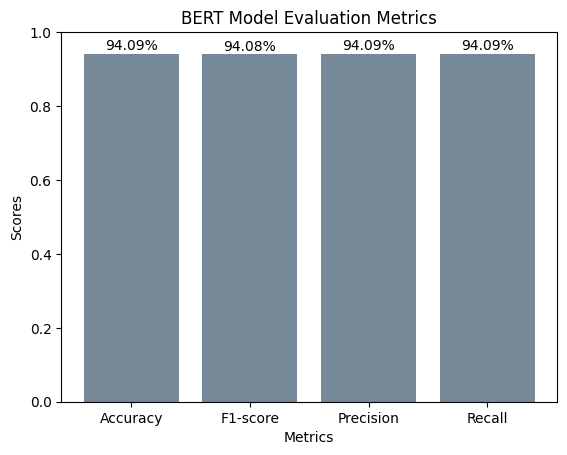

In [ ]:
bert_true_labels = df_test_headlines['Label'].tolist()
# calculate the accuracy score for the BERT model
bert_acc = accuracy_score(bert_true_labels, bert_predictions)

# calculate the F1-score for the BERT model
bert_f1 = f1_score(bert_true_labels, bert_predictions, average='weighted')

# calculate the precision score for the BERT model
bert_precision = precision_score(bert_true_labels, bert_predictions, average='weighted')

# calculate the recall score for the BERT model
bert_recall = recall_score(bert_true_labels, bert_predictions, average='weighted')

bert_metrics = [bert_acc, bert_f1, bert_precision, bert_recall]

print('BERT model:')
print("Accuracy score: {:.2%}".format(bert_acc))
print("F1-score: {:.2%}".format(bert_f1))
print("Precision score: {:.2%}".format(bert_precision))
print("Recall score: {:.2%}".format(bert_recall))

# plot the graph for evaluation metrics
plt.bar(metric_names, bert_metrics, color=['lightslategray'])
plt.title('BERT Model Evaluation Metrics')
plt.ylim(0.0, 1.0)
plt.xlabel('Metrics')
plt.ylabel('Scores')
for i, v in enumerate(bert_metrics):
    plt.text(i,  v + 0.01, '{:.2%}'.format(v), ha='center')
plt.show()

In [45]:
# print classification report
print(classification_report(bert_true_labels, bert_predictions, target_names=label_names))

               precision    recall  f1-score   support

Very Negative       0.81      0.80      0.81       220
     Negative       0.92      0.93      0.93      1643
      Neutral       0.97      0.97      0.97      3111
     Positive       0.93      0.92      0.93      1238
Very Positive       0.93      0.85      0.89       168

     accuracy                           0.94      6380
    macro avg       0.91      0.89      0.90      6380
 weighted avg       0.94      0.94      0.94      6380



BERT Confusion Matrix: 
 [[ 176   40    2    1    1]
 [  38 1534   53   18    0]
 [   1   57 3008   44    1]
 [   1   38   49 1142    8]
 [   0    1    2   22  143]]


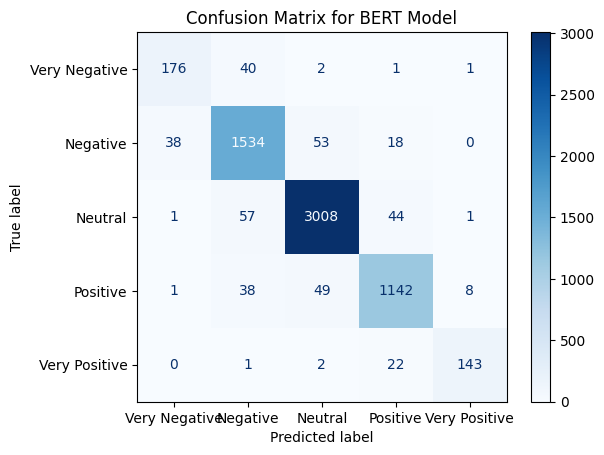

In [48]:
# calculate the confusion matrix
bert_cm = confusion_matrix(bert_true_labels, bert_predictions)

print("BERT Confusion Matrix: \n", bert_cm)

# plot the confusion matrix for BERT model
bert_displayCM = ConfusionMatrixDisplay(
    confusion_matrix=bert_cm, display_labels=label_names)
bert_displayCM.plot(cmap='Blues')
plt.title('Confusion Matrix for BERT Model')
plt.show()

## LSTM Model

In [202]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_time_series_inputs(df):
    scaled_data = minmax_scaler.fit_transform(df)

    x = []
    y = []

    for i in range(1, len(scaled_data)):
        x.append(scaled_data[i-1:i, :]) # Get all features for the timestep
        y.append(scaled_data[i, 0]) # Predict the first feature at the next timestep
    
    # Convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    return x, y

In [203]:
x_train_time, y_train_time = preprocess_time_series_inputs(time_train_data)
x_val_time, y_val_time = preprocess_time_series_inputs(time_validation_data)

(518, 1, 2) (518,) (64, 1, 2) (64,)


In [204]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(256, return_sequences=True, input_shape=(x_train_time.shape[1], x_train_time.shape[2])))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(25))
# output layer
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

# Train the model for 50 epochs with a batch size of 32
lstm_history = lstm_model.fit(x_train_time, y_train_time, batch_size=32, epochs=50, validation_data=(x_val_time, y_val_time))

# Save the model
lstm_model.save('lstm_model.h5')

Epoch 1/50
17/17 [==============================] - 8s 75ms/step - loss: 0.2158 - accuracy: 0.0019 - val_loss: 0.2344 - val_accuracy: 0.0156
Epoch 2/50
17/17 [==============================] - 0s 10ms/step - loss: 0.0449 - accuracy: 0.0039 - val_loss: 0.1012 - val_accuracy: 0.0312
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0274 - accuracy: 0.0039 - val_loss: 0.0923 - val_accuracy: 0.0312
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.0019 - val_loss: 0.0862 - val_accuracy: 0.0312
Epoch 5/50
17/17 [==============================] - 0s 10ms/step - loss: 0.0224 - accuracy: 0.0039 - val_loss: 0.0676 - val_accuracy: 0.0312
Epoch 6/50
17/17 [==============================] - 0s 10ms/step - loss: 0.0155 - accuracy: 0.0039 - val_loss: 0.0331 - val_accuracy: 0.0312
Epoch 7/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0052 - accuracy: 0.0039 - val_loss: 0.0087 - val_accuracy: 0.0312
Epoch 8/50
17/17

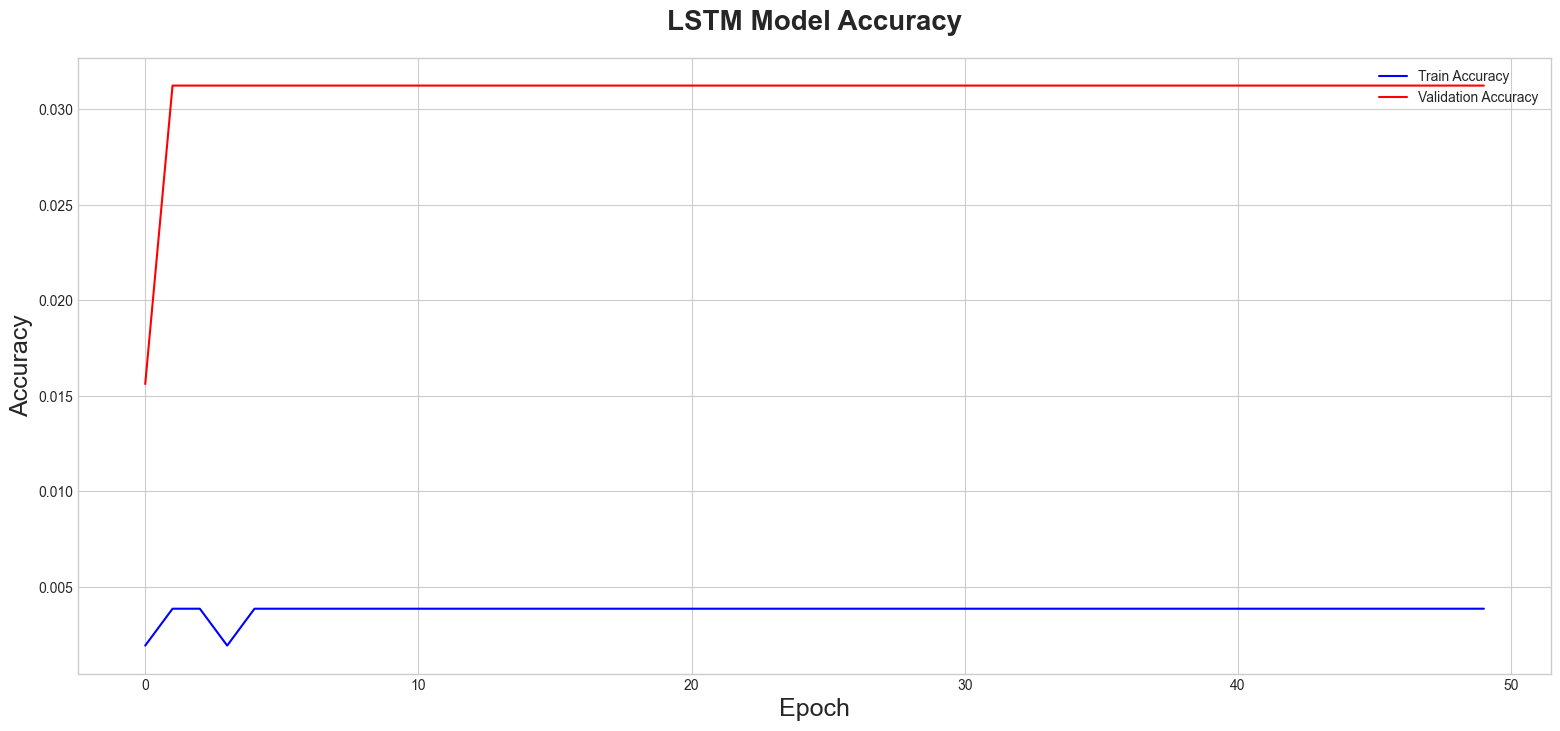

In [205]:
# plot accuracy
plt.figure(figsize=(19, 8))
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(loc='upper right')
plt.show()

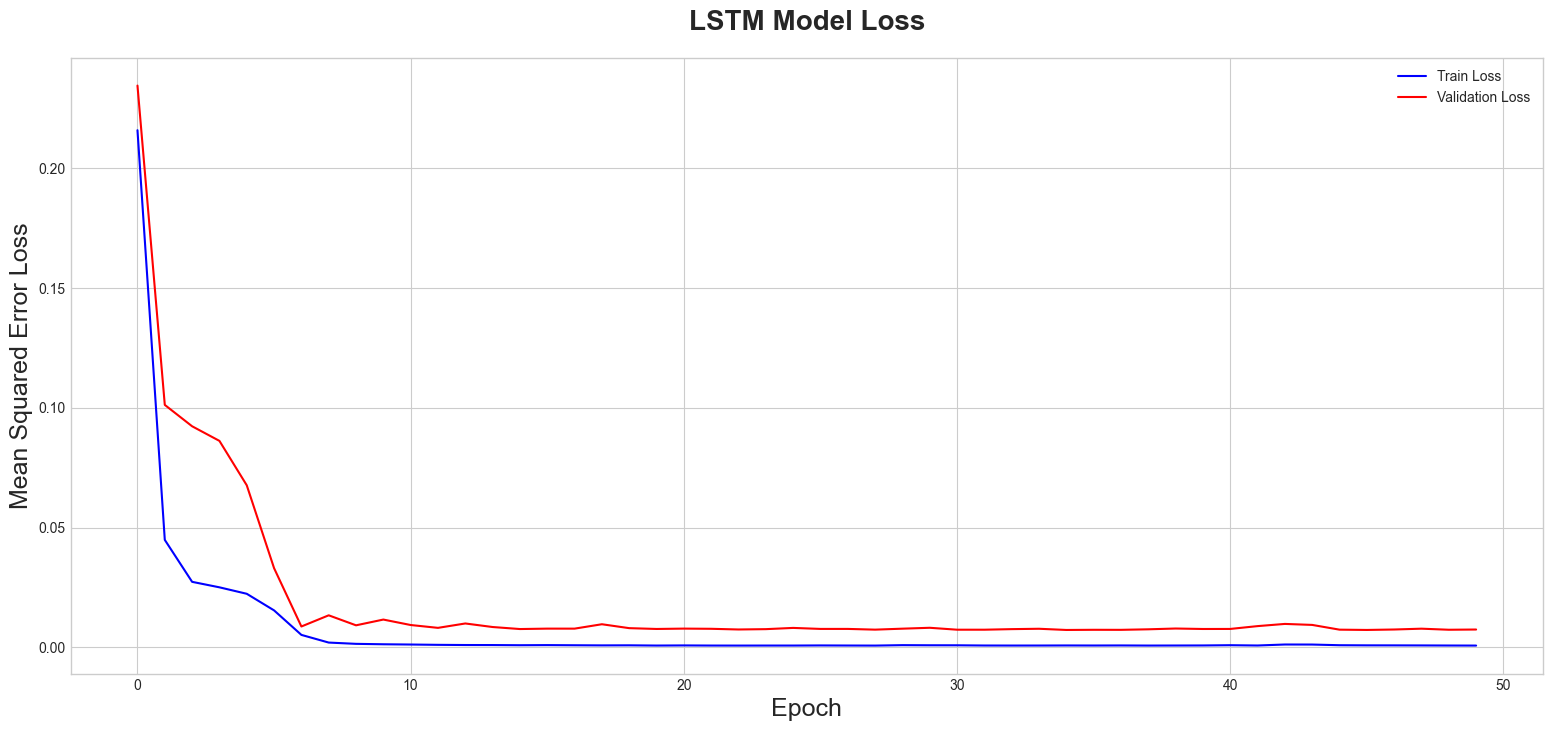

In [206]:
# Plot the training and validation loss
plt.figure(figsize=(19, 8))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Mean Squared Error Loss', fontsize=18)
plt.legend(loc='upper right')
plt.show()

### LSTM Model Evaluation

In [208]:
# Create a new DataFrame with dates and predictions
df_predictions = pd.DataFrame({'Date': df_test_headlines['Date'], 'Label': roberta_predictions})
df_roberta_labels = preprocess_stock_data_labels(time_test_data, df_predictions)
df_roberta_labels.head()

,Adj Close,Label
Date,,
2020-04-16,2799.550049,1.875000
2020-04-17,2874.560059,1.896226
2020-04-20,2823.159912,1.838980
2020-04-21,2736.560059,1.857143
2020-04-22,2799.310059,1.776119


In [209]:
x_test_time, y_test_time = preprocess_time_series_inputs(df_roberta_labels)

In [211]:
loaded_lstm_model = load_model('lstm_model.h5')
y_pred = loaded_lstm_model.predict(x_test_time)
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test_time, y_pred)
print('Mean Squared Error: ', mse)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error: ', rmse)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test_time, y_pred)
print('Mean Absolute Error: ', mae)

mda = np.mean(np.abs(y_test_time - y_pred))
print('Mean Directional Accuracy: ', mda)

# Calculate the R2 score
r2 = r2_score(y_test_time, y_pred)
print('R2 score: ', r2)

2/2 [==============================] - 1s 3ms/step
Mean Squared Error:  0.008830804538454567
Root Mean Squared Error:  0.09397236050272743
Mean Absolute Error:  0.07175068652069538
Mean Directional Accuracy:  0.3098327761153188
R2 score:  0.8812281875780075


In [227]:
y_pred_appended = np.concatenate((y_pred, x_test_time[:, :, 1]), axis=1)
y_pred_actual = minmax_scaler.inverse_transform(y_pred_appended)

In [235]:
# Create a new DataFrame with the actual and predicted stock prices
df_predictions = pd.DataFrame({'Date': df_roberta_labels.index[:-1], 'Actual': df_roberta_labels['Adj Close'][:-1], 'Predicted': y_pred_actual[:, 0]})
df_predictions.set_index('Date', inplace=True)

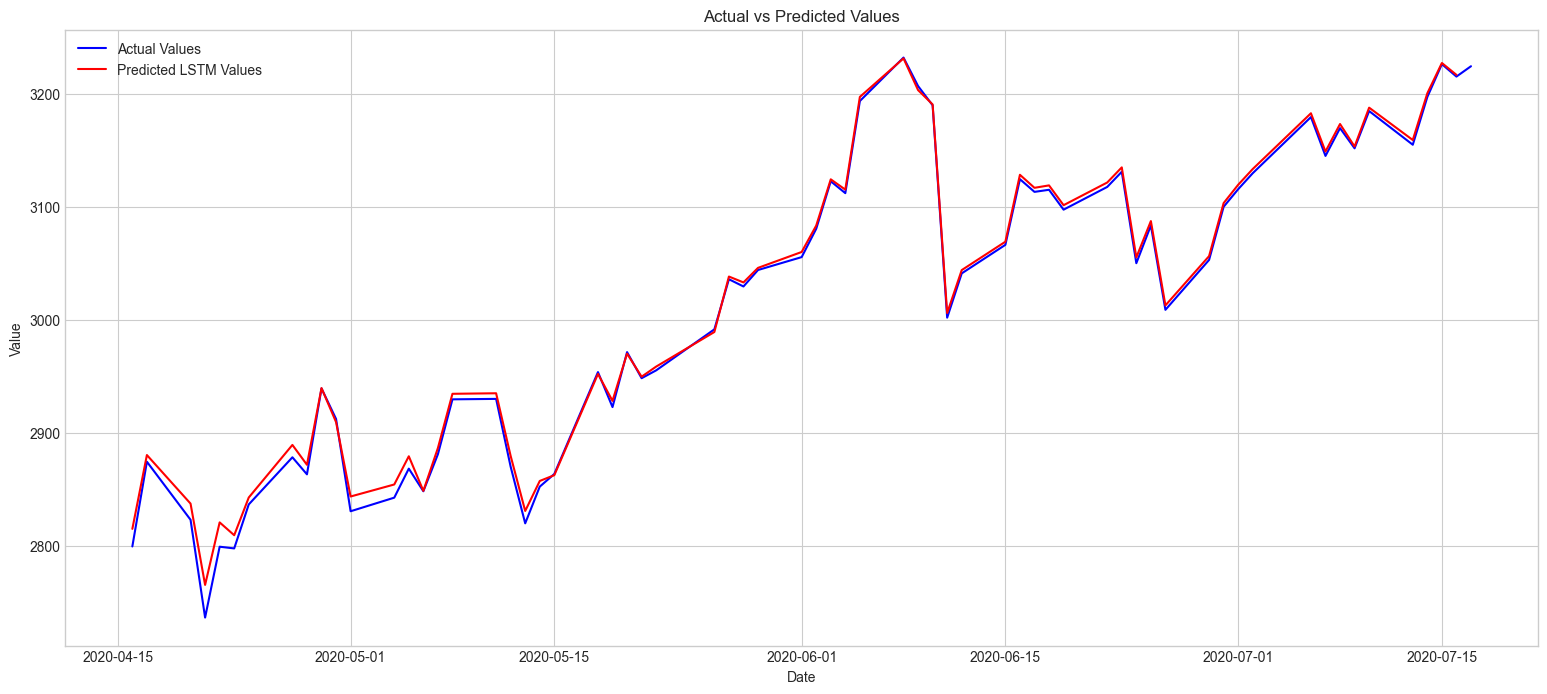

In [239]:
plt.figure(figsize=(19, 8))
plt.plot(df_roberta_labels['Adj Close'], label='Actual Values', color='b')
plt.plot(df_predictions['Predicted'], label='Predicted LSTM Values', color='r')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

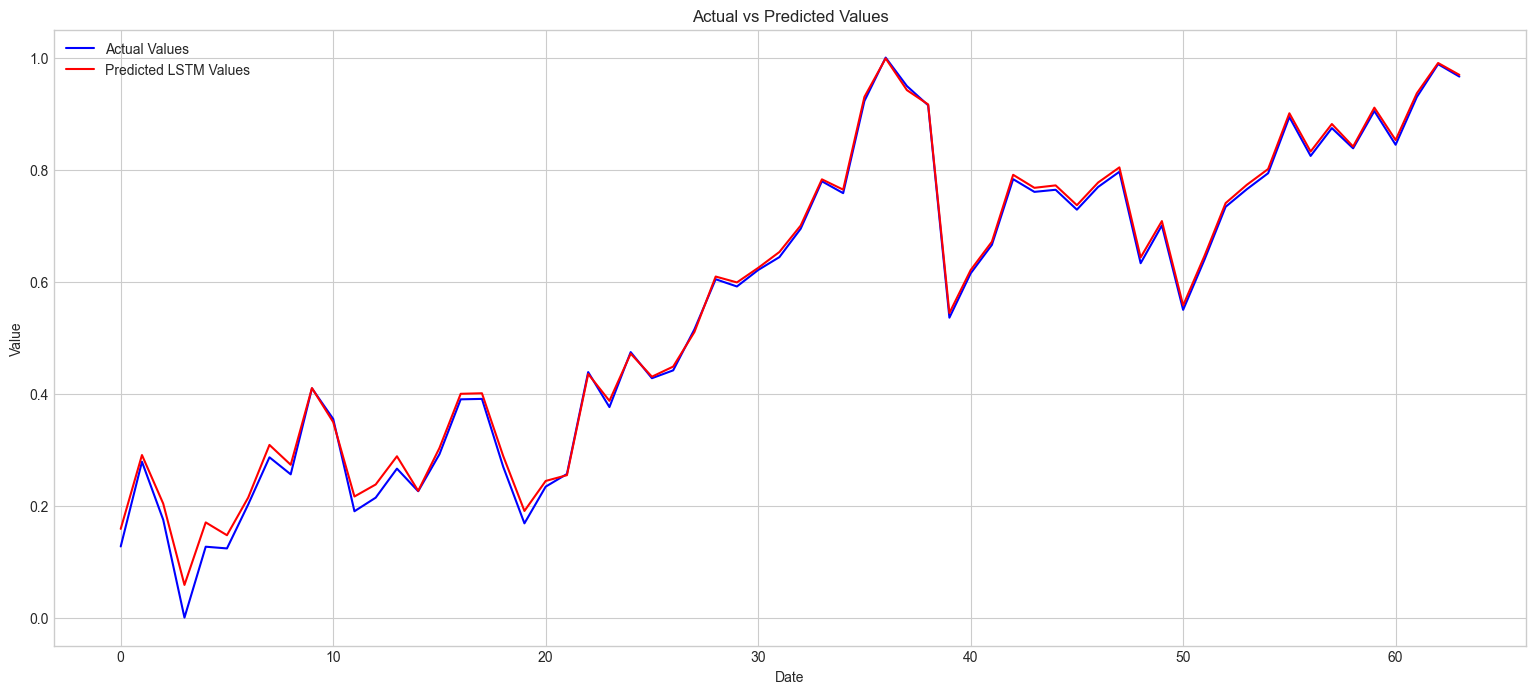

In [240]:
plt.figure(figsize=(19, 8))
plt.plot(x_test_time[:, :, 0], label='Actual Values', color='b')
plt.plot(y_pred, label='Predicted LSTM Values', color='r')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()